In [1]:
import nltk 
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
import pandas as pd
import chardet
from sentence_transformers import SentenceTransformer

import random
import numpy as np
import torch

import openai
import tiktoken
from bertopic.representation import OpenAI
from sklearn.cluster import KMeans

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Read json file into DataFrame


In [3]:
import pandas as pd
import json
file_path = r"C:\\Users\\Liu Shi Peng\\Documents\\chat_messages_202408081004.json"

with open(file_path, "rb") as f:
    json_file = json.load(f)

In [4]:
df = pd.DataFrame(list(json_file.values())[0])
docs = df['user_query'].tolist()
#print(sum(1 for i in docs if i == "yes")) - 455 messages only a single word of "yes"
#data['user_query'].groupby().head()
# x = df.groupby('user_query').count().reset_index() #.sort_values(ascending=False)
# x.sort_values(by=['message_id'], ascending = False).head(20)
len(docs)

200000

In [13]:
# slice only 5000 messages for initial modelling demo
docs = docs[:5000]

t = df.head(200000)
t['message_length'] = t['user_query'].apply(len)

# bins = [0, 10, 20, 30, 40, 50, 100, 200, 500, 1000]
# labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000']
# t['length_bin'] = pd.cut(t['message_length'], bins=bins, labels=labels, right=False)
# distribution_table = t['length_bin'].value_counts().sort_index()

# import seaborn as sns
# plt.hist(t['message_length'], color = 'blue', edgecolor = 'black',
#          bins = int(1000))
# #print(t)
# print(distribution_table)

min_length = t['message_length'].min()
max_length = t['message_length'].max()
print(f"Min length: {min_length}, Max length: {max_length}")

# Plotting the histogram
# plt.figure(figsize=(10, 6))
# plt.hist(t['message_length'], bins=range(min_length, max_length + 1), edgecolor='black', alpha=0.7)
# plt.title('Distribution of Message Lengths')
# plt.xlabel('Message Length')
# plt.ylabel('Number of Messages')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

Min length: 0, Max length: 416622


### create embeddings

In [ ]:
# # sentence transformers
embedding_model = SentenceTransformer('intfloat/multilingual-e5-large-instruct') #'intfloat/multilingual-e5-large-instruct', 'all-MiniLM-L6-v2', 'multilingual-e5-base'
embeddings = embedding_model.encode(docs, show_progress_bar=True)
with open("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_5k_e5_large.npy", 'wb') as f:
    np.save(f, embeddings)
# # The SentenceTransformers library focuses on generating contextual embeddings that capture the semantic meaning of sentences. 
# # It does not perform tasks like stemming, lemmatization, or manual stop word removal as these are not necessary for the model's purpose.
# # For better results, you might want to perform some preprocessing on your text before generating embeddings. This can include:
# # Removing or replacing URLs, special characters, and excessive whitespace.
# # Handling any specific text issues relevant to your data.

In [87]:
# # save embeddings, as its the part took the most time to generate
# # np.savetxt("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_multilingual_e5_0808.csv", embeddings, delimiter=",")
# with open("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_miniLM_0808.npy", 'wb') as f:
#     np.save(f, embeddings)

In [82]:
# b = np.load("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_miniLM_0808.npy")

In [7]:
embeddings = np.load("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_miniLM_0808.npy")
embeddings.shape

(100000, 384)

### Clustering

In [14]:
# from hdbscan import HDBSCAN
# hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [302]:
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
pca_embeddings = pca.fit_transform(embeddings)
pca_embeddings.shape

(100000, 250)

### use UMAP + Kmeans

Dimensions: 2, Silhouette Score: 0.35994574427604675
Dimensions: 3, Silhouette Score: 0.2978906035423279
Dimensions: 5, Silhouette Score: 0.2805221974849701
Dimensions: 15, Silhouette Score: 0.2668204605579376
Dimensions: 30, Silhouette Score: 0.2615569531917572
Dimensions: 50, Silhouette Score: 0.2757331430912018


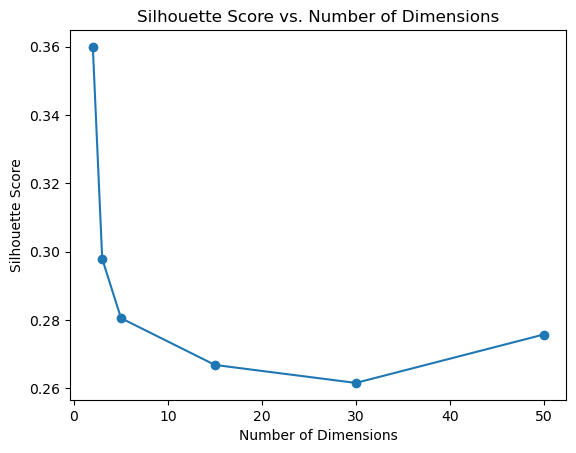

In [331]:
from umap import UMAP
from sklearn.metrics import silhouette_score
dimensions = [2,3,5, 15, 30, 50]

# Store the results
silhouette_scores = []

for dim in dimensions:
    # Apply UMAP
    reducer = UMAP(n_components=dim, random_state=42)
    X_reduced = reducer.fit_transform(embeddings)
    
    # Perform clustering (e.g., KMeans)
    kmeans = KMeans(n_clusters=10, random_state=42)  # Assuming 30 clusters as an example
    labels = kmeans.fit_predict(X_reduced)
    
    # Calculate the silhouette score
    score = silhouette_score(X_reduced, labels)
    silhouette_scores.append(score)
    print(f"Dimensions: {dim}, Silhouette Score: {score}")

# Plot silhouette scores to observe the trend
import matplotlib.pyplot as plt

plt.plot(dimensions, silhouette_scores, marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Dimensions')
plt.show()

# print out the score screenshot: 
# Dimensions: 2, Silhouette Score: 0.35994574427604675
# Dimensions: 3, Silhouette Score: 0.2978906035423279
# Dimensions: 5, Silhouette Score: 0.2805221974849701
# Dimensions: 15, Silhouette Score: 0.2668204605579376
# Dimensions: 30, Silhouette Score: 0.2615569531917572
# Dimensions: 50, Silhouette Score: 0.2757331430912018

### use UMAP + Kmeans with various clusters


Dimensions: 10, Silhouette Score: 0.21143142879009247
Dimensions: 10, Silhouette Score: 0.2708268165588379
Dimensions: 10, Silhouette Score: 0.3464502990245819


ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

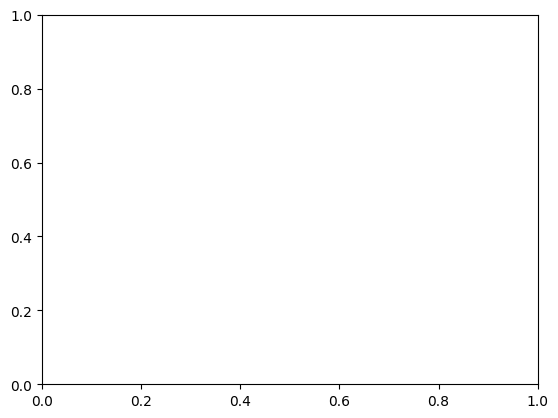

In [16]:
from umap import UMAP
from sklearn.metrics import silhouette_score
dimensions = [10]

# Store the results
silhouette_scores = []

for dim in dimensions:
    # Apply UMAP
    reducer = UMAP(n_components=dim, random_state=42)
    X_reduced = reducer.fit_transform(embeddings)

    for n in [5,10,30]:
    # Perform clustering (e.g., KMeans)
        kmeans = KMeans(n_clusters=n, random_state=42)  # Assuming 30 clusters as an example
        labels = kmeans.fit_predict(X_reduced)
        
        # Calculate the silhouette score
        score = silhouette_score(X_reduced, labels)
        silhouette_scores.append(score)
        print(f"Dimensions: {dim}, Silhouette Score: {score}")

# Plot silhouette scores to observe the trend
import matplotlib.pyplot as plt

plt.plot(dimensions, silhouette_scores, marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Dimensions')
plt.show()


# Dimensions: 2, Silhouette Score: 0.36958417296409607
# Dimensions: 2, Silhouette Score: 0.35994574427604675
# Dimensions: 2, Silhouette Score: 0.38588860630989075
# Dimensions: 3, Silhouette Score: 0.29093170166015625
# Dimensions: 3, Silhouette Score: 0.2994960844516754
# Dimensions: 3, Silhouette Score: 0.36470651626586914

Text(0, 0.5, 'Inertia')

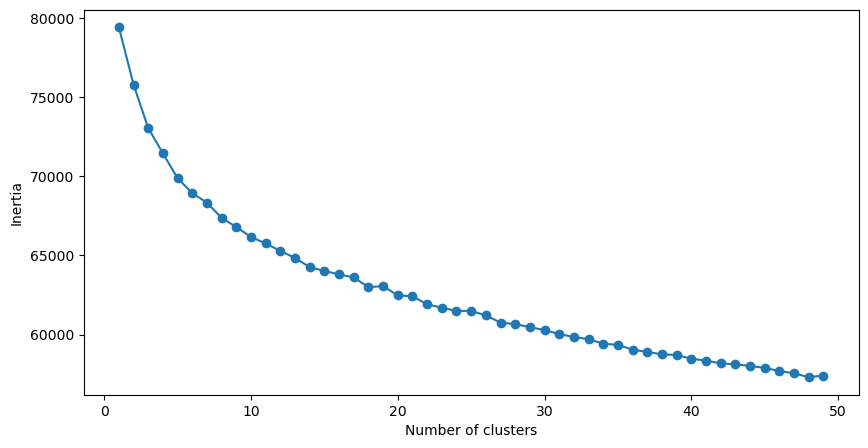

In [304]:
# fitting multiple k-means algorithms and storing the values in an empty list
import matplotlib.pyplot as plt
SSE = []
for cluster in range(1,50):
    kmeans = KMeans( n_clusters = cluster, init='k-means++', n_init = 2)
    kmeans.fit(pca_embeddings)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,50), 'SSE':SSE})
plt.figure(figsize=(10,5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [320]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n_clusters in range(5,51,10): 
    kmeans = KMeans(n_clusters = n_clusters, n_init = 1)
    kmeans.fit(pca_embeddings)
    kmeans_pred = kmeans.predict(pca_embeddings)
    silhouette_avg = silhouette_score(pca_embeddings, kmeans_pred)
    print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.04544895142316818
Silhouette Score: 0.05179673805832863
Silhouette Score: 0.04523620754480362
Silhouette Score: 0.0404563769698143
Silhouette Score: 0.038866642862558365
Silhouette Score: 0.04249269515275955
Silhouette Score: 0.05221964791417122
Silhouette Score: 0.04983271658420563
Silhouette Score: 0.05025041475892067
Silhouette Score: 0.05449675768613815


In [314]:
cluster_df = pd.DataFrame(pca_embeddings)
cluster_df['cluster'] = kmeans_pred
cluster_df['cluster'].value_counts()

cluster
10    6971
8     6060
0     5510
22    5216
7     5126
2     4566
14    4415
23    4326
24    4305
13    4257
12    4029
15    3997
19    3653
20    3539
21    3373
26    3337
27    2622
1     2528
17    2367
18    2248
5     2141
6     2139
4     2071
25    2068
29    1897
3     1864
9     1694
11    1435
28    1141
16    1105
Name: count, dtype: int64

In [316]:
# cluster_labels = kmeans.labels_
cluster_labels = kmeans_pred
cluster_labels.shape

(100000,)

### topic representation

In [266]:
unique_cluster_label = np.unique(cluster_labels)

def get_representative_queries(embeddings, labels, queries, num_representatives=30):
    representatives = {}
    for i in list(unique_cluster_label):
        cluster_indices = np.where(labels == i)[0]
        cluster_embeddings = embeddings[cluster_indices]
        cluster_center = kmeans.cluster_centers_[i]
        distances = np.linalg.norm(cluster_embeddings - cluster_center, axis=1)
        representative_indices = cluster_indices[np.argsort(distances)[:num_representatives]]
        representatives[i] = [queries[idx] for idx in representative_indices]
    return representatives

representative_queries = get_representative_queries(embeddings, cluster_labels, docs)

# for i in range(5):
#     print('topic_'+str(i))
#     print(*list(representative_queries[i]), sep = '\n')

In [268]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer_model = CountVectorizer(stop_words=["english", "spanish","chinese","french"], min_df=20, ngram_range=(1, 2))

### dimension reduction

In [271]:
# from bertopic.dimensionality import BaseDimensionalityReduction

# # Fit BERTopic without actually performing any dimensionality reduction
# empty_dimensionality_model = BaseDimensionalityReduction()
# topic_model = BERTopic(umap_model=empty_dimensionality_model)

### LLM text generation

In [282]:
client = openai.OpenAI(api_key="sk-proj-DlLitL7d2xVmr7pHyMmZT3BlbkFJfFwGzuOXpJF277sCKtgz")

def generate_topic_name_gpt35(queries, num_representatives=10):
    
    prompt = f"""
        You are an NLP expert, focusing on topic extraction. 
        Please generate a concise and reader-friendly topic name for the following queries.
        Keep the name within 20 words:\n\n
    """
    #If the queries are not finance related topics, please label it as "non finance topic", 
    for query in queries[:num_representatives]:
        prompt += f"- {query}\n"
    
    prompt += "\nTopic name (within 10 words):"

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an assistant that helps to summarize and name topics."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=50,
        #n=1,
        stop=None,
        temperature=0.5
    )

    return response.choices[0].message.content

topic_names = {}
for cluster_id, queries in representative_queries.items():
    topic_names[cluster_id] = generate_topic_name_gpt35(queries)


In [286]:
data = {
        "Topic ID": [],
        "Topic Name": [],
        "Representative Documents": []
    }

for cluster_id, queries in representative_queries.items():
    data["Topic ID"].append(cluster_id)
    data["Topic Name"].append(topic_names[cluster_id])
    data["Representative Documents"].append(queries)

df = pd.DataFrame(data)
df.to_csv("C:\\Users\\Liu Shi Peng\\Documents\\topic_sample_100k_miniLLM_breakdown_0810.csv")
df

,Topic ID,Topic Name,Representative Documents
0,0,Current and Future Price Inquiries.,"[what is the current price, What is the curren..."
1,1,"""Top Buying Choices""","[best option to buy, What would be a better op..."
2,2,Amplified Market Options Trading Analysis,[Give me an exact options trade detailing tick...
3,3,"""Top Options Trades for Today and Tomorrow""","[give me the best options trade to make today,..."
4,4,"""AI Implementation and Analysis for Stock Mark...","[provide further detail, implement it, its for..."
5,5,Quarterly Earnings Updates and Expectations,"[what was their previous quarter earnings?, wh..."
6,6,Current Top Stock Picks for Immediate Investment,"[What are the best stocks to buy right now, Wh..."
7,7,"""Short-term Options Trading Strategies for Var...",[What is the best call option to buy expiring ...
8,8,"Variations of ""okay"" in communication.","[okay, Okay, okay, okay, Okay, Okay, okay, oka..."
9,9,"""Top Crypto Investment Recommendations for Dif...","[What is the best crypto investment , what’s t..."


### LLM topic batch generation

In [256]:
# for cluster_id, queries in representative_queries.items():
#     print(cluster_id)
#     print(len(queries))

In [262]:
# Function to batch generate topic names
def generate_topic_names_batch_gpt35(representative_queries):
    prompt = "Generate distinct and reader-friendly topic names for the following clusters. \n"
    
    for cluster_id, queries in representative_queries.items():
        prompt += f"Cluster {cluster_id }:\n"  # Adjust cluster number to be 1-based if needed
        for query in queries[:10]:  # Limiting to 5 representative queries per cluster
            prompt += f"- {query}\n"
        prompt += "\n"
    
    prompt += f'''
        \nProvide the topic names for each cluster, keep the topic name within 5 words, and for each topic name, explain what each topic is about in 10 words
        
        please output in following format:
        'Cluster X: 
        <topic name>:
        <explanation>:
        '
    '''
#please ensure that each topic name is unique, specific and captures the essence and difference from each cluster. if cannot, pls show 'NA'
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an assistant that helps to summarize and name topics."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,  # Adjust as needed based on expected length
        #n=1,
        stop=None,
        temperature=0
    )

    return response.choices[0].message.content
   # return topic_names = response.choices[0].message.content#{int(name.split(': ')[0].split(' ')[-1]) - 1: name.split(': ')[1] for name in topic_names if ': ' in name}

# Example usage
topic_names = generate_topic_names_batch_gpt35(representative_queries)

In [263]:
print(generate_topic_names_batch_gpt35(representative_queries))

Cluster 0: 
Current Price Inquiry:
Seeking information on current and future prices of trades.

Cluster 1: 
Best Purchase Options:
Identifying optimal buying options for investments.

Cluster 2: 
Detailed Options Trading:
Specific options trade details for profitable market moves.

Cluster 3: 
Daily Options Trading:
Selecting options trades for daily trading activities.

Cluster 4: 
Further Trade Details:
Requesting additional information for strategic trading decisions.

Cluster 5: 
Earnings Report Analysis:
Exploring earnings data and stock performance insights.

Cluster 6: 
Top Stocks to Buy:
Identifying best stocks for immediate investment opportunities.

Cluster 7: 
Options Trade Recommendations:
Suggesting options trades with specific expiration dates and conditions.




In [31]:
# # Tokenizer
# tokenizer= tiktoken.encoding_for_model("gpt-3.5-turbo")

# # Create your representation model
# client = openai.OpenAI(api_key="sk-proj-DlLitL7d2xVmr7pHyMmZT3BlbkFJfFwGzuOXpJF277sCKtgz")

# prompt = """
#         I have a topic that contains the following documents: 
#         [DOCUMENTS]
#         The topic is described by the following keywords: [KEYWORDS]
        
#         Based on the information above, extract a short but highly descriptive topic label of at most 10 words. Make sure it is in the following format:
#         topic: <topic label>
#         """

# representation_model = OpenAI(
#     client,
#     model="gpt-3.5-turbo", 
#     delay_in_seconds=2, 
#     chat=True,
#     nr_docs=15,
#     doc_length=200,
#     tokenizer=tokenizer,
#     prompt=prompt
# )

#### Bertopic model training

In [33]:
# #fit the bertopic model, all using default parameters
# topic_model = BERTopic( 
#         # Pipeline models
#         embedding_model=embedding_model,
#         umap_model=empty_dimensionality_model,
#         hdbscan_model=kmeans_cluster_model, 
#         vectorizer_model=vectorizer_model,
#         representation_model=representation_model,
#         # Hyperparameters
#         top_n_words=25, 
#         verbose=True,
#         language="multilingual"
# )

In [35]:
# train the model
topics, probs = topic_model.fit_transform(docs, embeddings = embeddings)

2024-08-07 20:36:38,108 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-07 20:36:38,110 - BERTopic - Dimensionality - Completed ✓
2024-08-07 20:36:38,307 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-07 20:39:49,029 - BERTopic - Cluster - Completed ✓
2024-08-07 20:39:49,048 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 50/50 [02:13<00:00,  2.68s/it]
2024-08-07 20:42:07,158 - BERTopic - Representation - Completed ✓


In [37]:
# topic_model.get_topic_info().to_csv("C:\\Users\\Liu Shi Peng\\Documents\\topic_sample_50K_0807.csv")
# #topics = topic_model.generate_topic_labels(nr_words=50, separator=", ")
# topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,2721,0_Python logging best practices for machine le...,[Python logging best practices for machine lea...,"[Can you create Pine Script codes?, Hey TradeG..."
1,1,2380,1_Top Stock Opportunities for Short Squeeze Tr...,[Top Stock Opportunities for Short Squeeze Tra...,"[Top 3 stocks, stocks, Magnificent 7 stocks]"
2,2,2126,2_Polite Requests and Confirmations,[Polite Requests and Confirmations],"[yes please , Yes please, Yes please ]"
3,3,2066,3_Stock Analysis and Market Trends,[Stock Analysis and Market Trends],"[stock egas, Joby stock, FOMC stock ]"
4,4,1810,4_Latest News on Pinduoduo and Future Internet...,[Latest News on Pinduoduo and Future Internet ...,[is there any merger or going private news in ...
5,5,1793,5_Best Stocks to Buy Today,[Best Stocks to Buy Today],[Give me the best stock to buy! I want money n...
6,6,1674,6_Virtual Stock Market Guru TradeGPT Provides ...,[Virtual Stock Market Guru TradeGPT Provides A...,"[Hello, TradeGPT! Transform into the world-ren..."
7,7,1566,7_Market Sentiment and Trends Analysis: Today'...,[Market Sentiment and Trends Analysis: Today's...,"[Why is the market down today?, is the market ..."
8,8,1537,8_Current Price of Apple and Related Stocks,[Current Price of Apple and Related Stocks],"[what is the current price of apple, what is t..."
9,9,1386,9_Top 3 Profitable Trading Options Today,[Top 3 Profitable Trading Options Today],[What are the top 3 most profitable options fo...


In [39]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

# Print topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 49/49 [02:14<00:00,  2.74s/it]

.
├─Top Call Options Probability of Profit
│    ├─Expressing Approval and Encouragement
│    │    ├─■──Consensus on Response with Mixed Opinions ── Topic: 18
│    │    └─■──Polite Requests and Confirmations ── Topic: 2
│    └─High-probability Call Options for Various Stocks
│         ├─Top Call Options with Highest Profit Probability
│         │    ├─■──Top Call Options Profit Probability Analysis ── Topic: 38
│         │    └─Top AI Call Option Contracts for Profit
│         │         ├─■──Top AI Call Option Contracts for Profitability ── Topic: 48
│         │         └─■──Investing in AI Technology Stocks ── Topic: 41
│         └─■──Investment Strategies and Financial Analysis in Trading Markets ── Topic: 32
└─Options Trading Recommendations for Various Timeframes
     ├─Top Large Mid and Small Cap Stocks to Buy Today
     │    ├─■──Dividend Stock Analysis and Recommendations ── Topic: 36
     │    └─Best Stocks to Invest Today
     │         ├─Top Stocks to Buy for 10% Gain
     │  

In [ ]:
#topic_model.get_document_info(docs).to_csv("C:\\Users\\Liu Shi Peng\\Documents\\topic_sample_multilingual_e5_hdb_min_30.csv", index=False, escapechar='\\')
#doc_info[doc_info["Topic"]==2]["Document"].unique()
# doc_topic = topic_model.get_document_info(docs)
# doc_topic[doc_topic['Topic']==1].drop(['Topic', 'Representative_Docs', 'Representative_document', 'Representation', 'Name'], axis=1)

In [ ]:
# topic_model.visualize_barchart(width=280, height=330, top_n_topics = 10, n_words = 15)

In [ ]:
#topic_model.visualize_topics()
# topic_model.visualize_hierarchical_documents(docs,hierarchical_topics, width=280, height=330, )#visualize_hierarchy()
print(tree)

In [ ]:
# topic_model.get_topic(1, full=True)

In [ ]:
# #sub-model
# from sentence_transformers import SentenceTransformer
# embedding_model = SentenceTransformer("BAAI/bge-base-en-v1.5")

#### LLM text generation

In [ ]:
# import openai
# client = openai.OpenAI(api_key="sk-proj...")

# def generate_topic_description(topic_words):
#     prompt = f"""
#         Given the following list of keywords: {', '.join(topic_words)}
#         You are an NLP expert, focusing on topic extraction. Please: 
#         1. extract the topic these keywords represent, in less than 15 words
#         2. Provide a brief explanation of what this topic is about, in less than 30 words

#         In case of any foreign language keywords other than English, pls translate it in English first before considering in your summary.
#         Please output in this format:
#         Topic 1: 
#         Explanation: 
        
#         ...
#         """
#     response = client.chat.completions.create(
#         model="gpt-3.5-turbo",
#         messages=[
#             {"role": "system", "content": "You are a helpful assistant."},
#             {"role": "user", "content": prompt}
#         ]
#     )
#     return response.choices[0].message.content


In [ ]:
# descriptions = []
# for label in topics:
#     # Split the label string into a list of words
#     topic_words = [word.strip() for word in label.split(',')]
    
#     # Generate a description for this set of topic words
#     description = generate_topic_description(topic_words)
    
#     # Add the description to our list
#     descriptions.append(description)
# # print(descriptions, sep='\n')
# import textwrap
# def format_descriptions(descriptions, width=80):
#     formatted_descriptions = []
#     for desc in descriptions:
#         wrapped_desc = textwrap.fill(desc, width=width)
#         formatted_descriptions.append(wrapped_desc)
#     return formatted_descriptions
# formatted_descriptions = format_descriptions(descriptions)
# for desc in formatted_descriptions:
#     print(desc)
#     print()

In [ ]:
# from pandas import DataFrame
# from IPython.display import HTML
# HTML(DataFrame(descriptions).to_html())